# MNIST classification with FC/CNN using NumPy/PyTorch

## FC-NumPy

In [1]:
import urllib.request
import gzip
import pickle
import os
import numpy as np

url_base = 'http://yann.lecun.com/exdb/mnist/'
key_file = {
    'train_img':'train-images-idx3-ubyte.gz',
    'train_label':'train-labels-idx1-ubyte.gz',
    'test_img':'t10k-images-idx3-ubyte.gz',
    'test_label':'t10k-labels-idx1-ubyte.gz'
}

dataset_dir = os.getcwd() 
save_file = dataset_dir + "/mnist.pkl"

train_num = 60000
test_num = 10000
img_dim = (1, 28, 28)
img_size = 784

for file_name in key_file.values():
    
    file_path = dataset_dir + "/" + file_name
    
    if os.path.exists(file_path):
        continue
    
    print("Downloading " + file_name + " ... ")
    urllib.request.urlretrieve(url_base + file_name, file_path)
    print("Done")

def _load_label(file_name):
    file_path = dataset_dir + "/" + file_name
    
    print("Converting " + file_name + " to NumPy Array ...")
    with gzip.open(file_path, 'rb') as f:
            labels = np.frombuffer(f.read(), np.uint8, offset=8)
    print("Done")
    
    return labels

def _load_img(file_name):
    file_path = dataset_dir + "/" + file_name
    
    print("Converting " + file_name + " to NumPy Array ...")    
    with gzip.open(file_path, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, img_size)
    print("Done")
    
    return data

dataset = {}
dataset['train_img'] =  _load_img(key_file['train_img'])
dataset['train_label'] = _load_label(key_file['train_label'])    
dataset['test_img'] = _load_img(key_file['test_img'])
dataset['test_label'] = _load_label(key_file['test_label'])

print("Creating pickle file ...")
with open(save_file, 'wb') as f:
    pickle.dump(dataset, f, -1)
print("Done!")

Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!


In [2]:
with open(save_file, 'rb') as f:
    dataset = pickle.load(f)

print(type(dataset))
print(dataset.keys())
print(len(dataset['train_img']), len(dataset['test_img']), len(dataset['train_label']), len(dataset['test_label']))

<class 'dict'>
dict_keys(['train_img', 'train_label', 'test_img', 'test_label'])
60000 10000 60000 10000


In [3]:
def _into_one_hot_label(X):
    T = np.zeros((X.size, 10))
    for idx, row in enumerate(T):
        row[X[idx]] = 1
        
    return T
    
def load_mnist(flatten=True):

    with open(save_file, 'rb') as f:
        dataset = pickle.load(f)

    # normalize the pixel values between 0 and 1
    for key in ('train_img', 'test_img'):
        dataset[key] = dataset[key].astype(np.float32)
        dataset[key] /= 255.0
    
    # convert the label into one-hot label
    dataset['train_label'] = _into_one_hot_label(dataset['train_label'])
    dataset['test_label'] = _into_one_hot_label(dataset['test_label'])    
    
    # flatten
    if not flatten:
         for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].reshape(-1, 1, 28, 28)

    return (dataset['train_img'], dataset['train_label']), (dataset['test_img'], dataset['test_label']) 

(x_train, t_train), (x_test, t_test) = load_mnist(flatten=True)

x_batch = x_train[:2]
t_batch = t_train[:2]

print(x_batch.shape)
print(x_batch)
print(t_batch.shape)
print(t_batch)

(2, 784)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(2, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [4]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 가중치와 편향 매개변수의 미분
        self.dW = None
        self.db = None

    def forward(self, x):
        # 텐서 대응
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 입력 데이터 모양 변경(텐서 대응)
        return dx

class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실함수
        self.y = None    # softmax의 출력
        self.t = None    # 정답 레이블(원-핫 인코딩 형태)
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 정답 레이블이 원-핫 인코딩 형태일 때
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx
    
def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 값 복원
        it.iternext()   
        
    return grad

In [5]:
from collections import OrderedDict

class FCNumPyMNISTClassifier:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        
        # parameters
        self.params = {}
        self.params['W1'] = np.random.randn(input_size, hidden_size) * weight_init_std
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = np.random.randn(hidden_size, output_size) * weight_init_std
        self.params['b2'] = np.zeros(output_size)

        # affine-relu-affine-softmaxCE
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db

        return grads
    
model = FCNumPyMNISTClassifier(input_size=784, hidden_size=100, output_size=10)

In [6]:
grad_numerical = model.numerical_gradient(x_batch, t_batch)
grad_backprop = model.gradient(x_batch, t_batch)

for key in grad_numerical.keys():
    diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
    print(key + ":" + str(diff))

W1:5.024020435594987e-10
b1:3.0673714093217034e-09
W2:5.279488153366296e-09
b2:1.6060616138402484e-07


In [7]:
epochs = 20
batch_size = 100
learning_rate = 0.1
iter_per_epoch = x_train.shape[0]//batch_size

for i in range(epochs * iter_per_epoch):
    
    batch_mask = np.random.choice(x_train.shape[0], batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    loss = model.loss(x_batch, t_batch)

    # grad = model.numerical_gradient(x_batch, t_batch)
    grad = model.gradient(x_batch, t_batch)
    
    for key in ('W1', 'b1', 'W2', 'b2'):
        model.params[key] -= learning_rate * grad[key]
    
    if i % iter_per_epoch == 0:
        train_acc = model.accuracy(x_train, t_train)
        test_acc = model.accuracy(x_test, t_test)
        print(f'{train_acc:.4f}, {test_acc:.4f}')

0.0878, 0.0866
0.9057, 0.9088
0.9253, 0.9269
0.9386, 0.9391
0.9465, 0.9449
0.9558, 0.9524
0.9596, 0.9542
0.9657, 0.9624
0.9696, 0.9645
0.9725, 0.9681
0.9753, 0.9701
0.9771, 0.9697
0.9788, 0.9728
0.9799, 0.9720
0.9820, 0.9732
0.9830, 0.9751
0.9836, 0.9758
0.9849, 0.9750
0.9857, 0.9754
0.9869, 0.9771


Label: 7
Prediction: 7


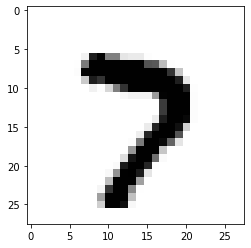

In [8]:
import random
import matplotlib.pyplot as plt

r = random.randint(0, len(dataset['test_img'])-1)
X_random = dataset['test_img'][r:r+1]
Y_random = dataset['test_label'][r:r+1]

print(f"Label: {Y_random[0]}")
print(f"Prediction: {np.argmax(softmax(model.predict(X_random)))}")
plt.imshow(X_random.reshape(28, 28), cmap='Greys', interpolation='nearest')
plt.show()

## CNN-NumPy

In [9]:
import urllib.request
import gzip
import pickle
import os
import numpy as np

url_base = 'http://yann.lecun.com/exdb/mnist/'
key_file = {
    'train_img':'train-images-idx3-ubyte.gz',
    'train_label':'train-labels-idx1-ubyte.gz',
    'test_img':'t10k-images-idx3-ubyte.gz',
    'test_label':'t10k-labels-idx1-ubyte.gz'
}

dataset_dir = os.getcwd() 
save_file = dataset_dir + "/mnist.pkl"

train_num = 60000
test_num = 10000
img_dim = (1, 28, 28)
img_size = 784

for file_name in key_file.values():
    
    file_path = dataset_dir + "/" + file_name
    
    if os.path.exists(file_path):
        continue
    
    print("Downloading " + file_name + " ... ")
    urllib.request.urlretrieve(url_base + file_name, file_path)
    print("Done")

def _load_label(file_name):
    file_path = dataset_dir + "/" + file_name
    
    print("Converting " + file_name + " to NumPy Array ...")
    with gzip.open(file_path, 'rb') as f:
            labels = np.frombuffer(f.read(), np.uint8, offset=8)
    print("Done")
    
    return labels

def _load_img(file_name):
    file_path = dataset_dir + "/" + file_name
    
    print("Converting " + file_name + " to NumPy Array ...")    
    with gzip.open(file_path, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, img_size)
    print("Done")
    
    return data

dataset = {}
dataset['train_img'] =  _load_img(key_file['train_img'])
dataset['train_label'] = _load_label(key_file['train_label'])    
dataset['test_img'] = _load_img(key_file['test_img'])
dataset['test_label'] = _load_label(key_file['test_label'])

print("Creating pickle file ...")
with open(save_file, 'wb') as f:
    pickle.dump(dataset, f, -1)
print("Done!")

Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!


In [10]:
with open(save_file, 'rb') as f:
    dataset = pickle.load(f)

print(type(dataset))
print(dataset.keys())
print(len(dataset['train_img']), len(dataset['test_img']), len(dataset['train_label']), len(dataset['test_label']))

<class 'dict'>
dict_keys(['train_img', 'train_label', 'test_img', 'test_label'])
60000 10000 60000 10000


In [11]:
def _into_one_hot_label(X):
    T = np.zeros((X.size, 10))
    for idx, row in enumerate(T):
        row[X[idx]] = 1
        
    return T
    
def load_mnist(flatten=True):

    with open(save_file, 'rb') as f:
        dataset = pickle.load(f)

    # normalize the pixel values between 0 and 1
    for key in ('train_img', 'test_img'):
        dataset[key] = dataset[key].astype(np.float32)
        dataset[key] /= 255.0
    
    # convert the label into one-hot label
    dataset['train_label'] = _into_one_hot_label(dataset['train_label'])
    dataset['test_label'] = _into_one_hot_label(dataset['test_label'])    
    
    # flatten
    if not flatten:
         for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].reshape(-1, 1, 28, 28)

    return (dataset['train_img'], dataset['train_label']), (dataset['test_img'], dataset['test_label']) 

(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

x_batch = x_train[:2]
t_batch = t_train[:2]

print(x_batch.shape)
print(x_batch)
print(t_batch.shape)
print(t_batch)

(2, 1, 28, 28)
[[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]]
(2, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [12]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 가중치와 편향 매개변수의 미분
        self.dW = None
        self.db = None

    def forward(self, x):
        # 텐서 대응
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 입력 데이터 모양 변경(텐서 대응)
        return dx

class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """다수의 이미지를 입력받아 2차원 배열로 변환한다(평탄화).
    
    Parameters
    ----------
    input_data : 4차원 배열 형태의 입력 데이터(이미지 수, 채널 수, 높이, 너비)
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    col : 2차원 배열
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """(im2col과 반대) 2차원 배열을 입력받아 다수의 이미지 묶음으로 변환한다.
    
    Parameters
    ----------
    col : 2차원 배열(입력 데이터)
    input_shape : 원래 이미지 데이터의 형상（예：(10, 1, 28, 28)）
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    img : 변환된 이미지들
    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 중간 데이터（backward 시 사용）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 가중치와 편향 매개변수의 기울기
        self.dW = None
        self.db = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx

class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx
    
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실함수
        self.y = None    # softmax의 출력
        self.t = None    # 정답 레이블(원-핫 인코딩 형태)
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 정답 레이블이 원-핫 인코딩 형태일 때
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx
    
def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 값 복원
        it.iternext()   
        
    return grad

In [13]:
from collections import OrderedDict

class CNNNumPyMNISTClassifier:

    def __init__(self, 
                 input_dim=(1, 28, 28), 
                 conv1_out_channel=32, 
                 conv2_out_channel=64,
                 output_size=10, 
                 filter_size = 3,
                 filter_pad = 1,
                 filter_stride = 1,
                 weight_init_std=0.01):
        
        # affine_in_feature을 구하기 위한 과정
        input_width = input_dim[1]
        # 28
        conv1_out_width = int((input_width - filter_size + 2*filter_pad) / filter_stride + 1)
        # 28
        pool1_out_width = conv1_out_width//2
        # 14
        conv2_out_width = int((pool1_out_width - filter_size + 2*filter_pad) / filter_stride + 1)
        # 14
        pool2_out_width = conv2_out_width//2
        # 7
        affine_in_feature = int(conv2_out_channel * pool2_out_width * pool2_out_width)
        # 3136

        # parameters
        self.params = {}
        self.params['W1'] = np.random.randn(conv1_out_channel, input_dim[0], filter_size, filter_size) * weight_init_std
        self.params['b1'] = np.zeros(conv1_out_channel)
        self.params['W2'] = np.random.randn(conv2_out_channel, conv1_out_channel, filter_size, filter_size) * weight_init_std
        self.params['b2'] = np.zeros(conv2_out_channel)
        self.params['W3'] = np.random.randn(affine_in_feature, output_size) * weight_init_std
        self.params['b3'] = np.zeros(output_size)

        # conv-relu-pool-conv-relu-pool-affine-softmaxCE
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'], stride=filter_stride, pad=filter_pad)
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Conv2'] = Convolution(self.params['W2'], self.params['b2'], stride=filter_stride, pad=filter_pad)
        self.layers['Relu2'] = Relu()
        self.layers['Pool2'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy    
    
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        grads['W3'] = numerical_gradient(loss_W, self.params['W3'])
        grads['b3'] = numerical_gradient(loss_W, self.params['b3'])        

        return grads

    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'] = self.layers['Conv1'].dW
        grads['b1'] = self.layers['Conv1'].db
        grads['W2'] = self.layers['Conv2'].dW
        grads['b2'] = self.layers['Conv2'].db
        grads['W3'] = self.layers['Affine'].dW
        grads['b3'] = self.layers['Affine'].db

        return grads
    
model = CNNNumPyMNISTClassifier(input_dim=(1, 28, 28), 
                                conv1_out_channel=32, 
                                conv2_out_channel=64,
                                output_size=10)

In [14]:
grad_numerical = model.numerical_gradient(x_batch, t_batch)
grad_backprop = model.gradient(x_batch, t_batch)

for key in grad_numerical.keys():
    diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
    print(key + ":" + str(diff))

W1:4.5971456179127626e-05
b1:0.0029062804043156303
W2:6.006672755723734e-07
b2:0.008121639318308388
W3:1.1912013437527102e-10
b3:1.5994033273486474e-07


In [15]:
epochs = 20
batch_size = 100
learning_rate = 0.01
iter_per_epoch = x_train.shape[0]//batch_size

for i in range(epochs * iter_per_epoch):
    
    batch_mask = np.random.choice(x_train.shape[0], batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    loss = model.loss(x_batch, t_batch)

    # grad = model.numerical_gradient(x_batch, t_batch)
    grad = model.gradient(x_batch, t_batch)
    
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        model.params[key] -= learning_rate * grad[key]
    
    if i % iter_per_epoch == 0:
        train_acc = model.accuracy(x_train, t_train)
        test_acc = model.accuracy(x_test, t_test)
        print(f'{train_acc:.4f}, {test_acc:.4f}')

0.1112, 0.1075
0.1124, 0.1135
0.7983, 0.8090
0.8894, 0.8964
0.9071, 0.9151
0.9177, 0.9259
0.9380, 0.9419
0.9409, 0.9437
0.9527, 0.9556
0.9604, 0.9643
0.9634, 0.9629
0.9659, 0.9688
0.9681, 0.9674
0.9704, 0.9707
0.9704, 0.9707
0.9753, 0.9747
0.9723, 0.9732
0.9772, 0.9756
0.9781, 0.9763
0.9786, 0.9775


Label: 1
Prediction: 1


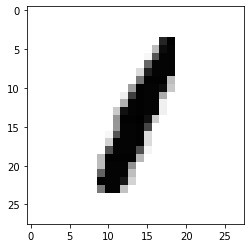

In [16]:
import random
import matplotlib.pyplot as plt

r = random.randint(0, len(dataset['test_img'])-1)
X_random = dataset['test_img'][r:r+1].reshape(28, 28)
Y_random = dataset['test_label'][r:r+1]

print(f"Label: {Y_random[0]}")
print(f"Prediction: {np.argmax(softmax(model.predict(np.expand_dims(np.expand_dims(X_random, 0), 0))))}")
plt.imshow(X_random, cmap='Greys', interpolation='nearest')
plt.show()

## FC-PyTorch

In [17]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [19]:
random.seed(42)
torch.manual_seed(42)
if device=='cuda':
    torch.cuda.manual_seed(42)

In [20]:
mnist_train = datasets.MNIST(root=".",
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)

mnist_test = datasets.MNIST(root=".",
                           train=False,
                           transform=transforms.ToTensor(),
                           download=True)

In [21]:
batch_size = 100
dataloader = DataLoader(dataset=mnist_train,
                       batch_size=batch_size,
                       shuffle=True,
                       drop_last=True)

In [22]:
class FCPyTorchMNISTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer1 = nn.Sequential(
            nn.Linear(784, 100),
            nn.ReLU(),
            nn.Linear(100, 10)
        )

    def forward(self, x):
        x = self.layer1(x)
        
        return x
    
model = FCPyTorchMNISTClassifier()
print(model)

FCPyTorchMNISTClassifier(
  (layer1): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=10, bias=True)
  )
)


In [23]:
from torchsummary import summary

summary(model, input_size=(100, 784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 100, 100]          78,500
              ReLU-2             [-1, 100, 100]               0
            Linear-3              [-1, 100, 10]           1,010
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.30
Forward/backward pass size (MB): 0.16
Params size (MB): 0.30
Estimated Total Size (MB): 0.76
----------------------------------------------------------------


In [24]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [25]:
epochs = 20
for epoch in range(epochs+1):
    
    avg_cost = 0
    total_batch = len(dataloader)
    
    for X, Y in dataloader:
        X = X.view(-1, 28*28).to(device)
        Y = Y.to(device)
        
        optimizer.zero_grad()
        pred = model(X)
        cost = criterion(pred, Y)
        cost.backward()
        optimizer.step()
        
        avg_cost += cost/total_batch
        
    print(f'Epoch: {epoch:4d} Cost: {avg_cost:.6f}')

Epoch:    0 Cost: 0.523085
Epoch:    1 Cost: 0.273585
Epoch:    2 Cost: 0.220413
Epoch:    3 Cost: 0.184676
Epoch:    4 Cost: 0.158337
Epoch:    5 Cost: 0.137529
Epoch:    6 Cost: 0.121570
Epoch:    7 Cost: 0.108772
Epoch:    8 Cost: 0.098338
Epoch:    9 Cost: 0.089907
Epoch:   10 Cost: 0.082451
Epoch:   11 Cost: 0.076391
Epoch:   12 Cost: 0.071078
Epoch:   13 Cost: 0.065836
Epoch:   14 Cost: 0.061706
Epoch:   15 Cost: 0.057744
Epoch:   16 Cost: 0.054726
Epoch:   17 Cost: 0.051594
Epoch:   18 Cost: 0.048461
Epoch:   19 Cost: 0.045837
Epoch:   20 Cost: 0.043598


Accuracy: 0.9739
Label: 2
Prediction: 2


/opt/homebrew/Caskroom/miniconda/base/envs/xcda/lib/python3.8/site-packages/torchvision/datasets/mnist.py:69: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/opt/homebrew/Caskroom/miniconda/base/envs/xcda/lib/python3.8/site-packages/torchvision/datasets/mnist.py:59: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


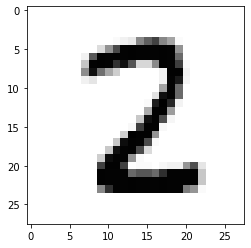

In [26]:
import random
import matplotlib.pyplot as plt

with torch.no_grad():
    X_test = mnist_test.test_data.view(-1, 28*28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)
    
    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1)==Y_test
    accuracy = correct_prediction.float().mean()
    print(f"Accuracy: {accuracy.item():.4f}")
    
    r = random.randint(0, len(mnist_test)-1)
    X_random = mnist_test.test_data[r:r+1].view(-1, 28*28).float().to(device)
    Y_random = mnist_test.test_labels[r:r+1].to(device)
    
    print(f"Label: {Y_random.item()}")
    single_prediction = model(X_random)
    print(f"Prediction: {torch.argmax(model(X_random), 1).item()}")
    plt.imshow(mnist_test.test_data[r:r+1].view(28, 28), cmap='Greys', interpolation='nearest')
    plt.show()

## CNN-PyTorch

In [27]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [29]:
random.seed(42)
torch.manual_seed(42)
if device=='cuda':
    torch.cuda.manual_seed(42)

In [30]:
mnist_train = datasets.MNIST(root=".",
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)

mnist_test = datasets.MNIST(root=".",
                           train=False,
                           transform=transforms.ToTensor(),
                           download=True)

In [31]:
batch_size = 100
dataloader = DataLoader(dataset=mnist_train,
                       batch_size=batch_size,
                       shuffle=True,
                       drop_last=True)

In [32]:
class CNNPyTorchMNISTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc = nn.Linear(7*7*64, 10)
        nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x
    
model = CNNPyTorchMNISTClassifier()
print(model)

CNNPyTorchMNISTClassifier(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=3136, out_features=10, bias=True)
)


In [33]:
from torchsummary import summary

summary(model, input_size=(1, 28, 28), batch_size=100)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [100, 32, 28, 28]             320
              ReLU-2          [100, 32, 28, 28]               0
         MaxPool2d-3          [100, 32, 14, 14]               0
            Conv2d-4          [100, 64, 14, 14]          18,496
              ReLU-5          [100, 64, 14, 14]               0
         MaxPool2d-6            [100, 64, 7, 7]               0
            Linear-7                  [100, 10]          31,370
Total params: 50,186
Trainable params: 50,186
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.30
Forward/backward pass size (MB): 64.61
Params size (MB): 0.19
Estimated Total Size (MB): 65.10
----------------------------------------------------------------


In [34]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [35]:
epochs = 20
for epoch in range(epochs+1):
    
    avg_cost = 0
    total_batch = len(dataloader)

    for X, Y in dataloader:
        X = X.to(device)
        Y = Y.to(device)
        
        optimizer.zero_grad()
        pred = model(X)
        cost = criterion(pred, Y)
        cost.backward()
        optimizer.step()
        
        avg_cost += cost/total_batch
        
    print(f'Epoch: {epoch:4d} Cost: {avg_cost:.6f}')

Epoch:    0 Cost: 0.950457
Epoch:    1 Cost: 0.326900
Epoch:    2 Cost: 0.254949
Epoch:    3 Cost: 0.206060
Epoch:    4 Cost: 0.170603
Epoch:    5 Cost: 0.144487
Epoch:    6 Cost: 0.125992
Epoch:    7 Cost: 0.112185
Epoch:    8 Cost: 0.101375
Epoch:    9 Cost: 0.093899
Epoch:   10 Cost: 0.087399
Epoch:   11 Cost: 0.081997
Epoch:   12 Cost: 0.077801
Epoch:   13 Cost: 0.074023
Epoch:   14 Cost: 0.070530
Epoch:   15 Cost: 0.067960
Epoch:   16 Cost: 0.065175
Epoch:   17 Cost: 0.062499
Epoch:   18 Cost: 0.060749
Epoch:   19 Cost: 0.058910
Epoch:   20 Cost: 0.057172


Accuracy: 0.9820
Label: 2
Prediction: 2


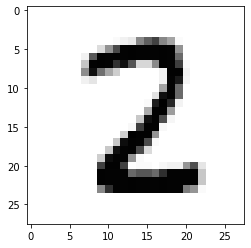

In [36]:
import random
import matplotlib.pyplot as plt

with torch.no_grad():
    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)
    
    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1)==Y_test
    accuracy = correct_prediction.float().mean()
    print(f"Accuracy: {accuracy.item():.4f}")
    
    r = random.randint(0, len(mnist_test)-1)
    X_random = torch.unsqueeze(mnist_test.test_data[r:r+1].float().to(device), 0)
    Y_random = mnist_test.test_labels[r:r+1].to(device)
    
    print(f"Label: {Y_random.item()}")
    single_prediction = model(X_random)
    print(f"Prediction: {torch.argmax(model(X_random), 1).item()}")
    plt.imshow(mnist_test.test_data[r:r+1].view(28, 28), cmap='Greys', interpolation='nearest')
    plt.show()